In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   ravenna
   2   cosenza
   3   ancona
   4   bolzano
   5   cagliari
   6   mantova
   7   siena
   8   venezia
   9   belluno
   10   vercelli
   11   campobasso
   12   sondrio
   13   livorno
   14   novara
   15   siracusa
   16   oristano
   17   trieste
   18   piacenza
   19   catania
   20   vicenza
   21   prato
   22   isernia
   23   massa
   24   catanzaro
   25   biella
   26   matera
   27   messina
   28   forli
   29   pescara
   30   crotone
   31   trapani
   32   rovigo
   33   brescia
   34   enna
   35   terni
   36   viterbo
   37   teramo
   38   modena
   39   genova
   40   rieti
   41   lecco
   42   chieti
   43   trento
   44   vibo_valentia
   45   pistoia
   46   asti
   47   reggio_di_calabria
   48   salerno
   49   verona
   50   milano
   51   nuoro
   52   frosinone
   53   ragusa
   54   caltanissetta
   55   bergamo
   56   treviso
   57   perugia
   58   parma
   59   l

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 ravenna
2 cosenza
3 ancona
4 bolzano
5 cagliari
6 mantova
7 siena
8 venezia
9 belluno
10 vercelli
11 campobasso
12 sondrio
13 livorno
14 novara
15 siracusa
16 oristano
17 trieste
18 piacenza
19 catania
20 vicenza
21 prato
22 massa
23 catanzaro
24 biella
25 matera
26 messina
27 forli
28 pescara
29 crotone
30 trapani
31 rovigo
32 brescia
33 enna
34 terni
35 viterbo
36 teramo
37 modena
38 genova
39 rieti
40 lecco
41 chieti
42 trento
43 vibo_valentia
44 pistoia
45 asti
46 reggio_di_calabria
47 salerno
48 verona
49 milano
50 nuoro
51 frosinone
52 ragusa
53 caltanissetta
54 bergamo
55 treviso
56 perugia
57 parma
58 la_spezia
59 napoli
60 latina
61 agrigento
62 roma
63 palermo
64 udine
65 grosseto
66 cremona
67 pisa
68 ascoli_piceno
69 como
70 firenze
71 ferrara
72 lecce
73 imperia
74 pordenone
75 reggio_nell_emilia
76 pavia
77 monza
78 macerata
79 foggia
80 verbania
81 savona
82 varese
83 arezzo
84 cuneo
85 fermo
86 bologna
87 sassari
88 potenza
89 bat
90 lucca
91 taranto
92 padova
93 avel

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35289  0.02155 
    Test set average RMSE:  0.94279  0.08938 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34881
                       R2:  0.94432


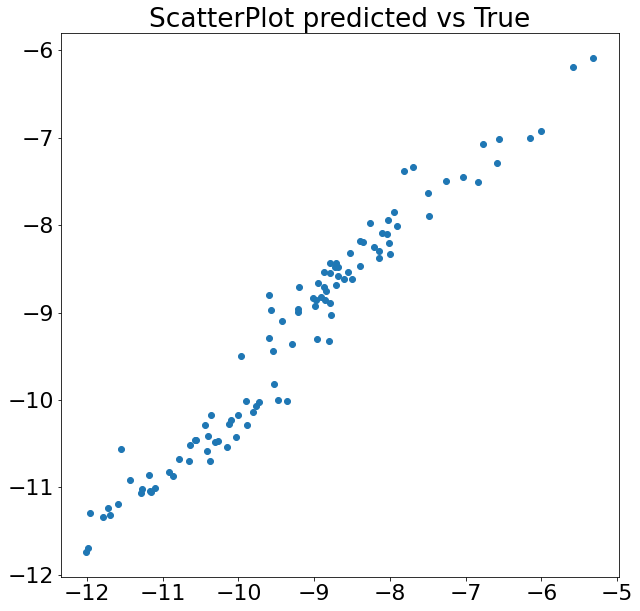

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02154
Feature:               commutersdensity, Score: 0.01913
Feature:                         depriv, Score: 0.01820
Feature:                            lat, Score: 0.63443
Feature:                 Ratio0200ver65, Score: 0.04821
Feature:         avg_wpm10_period1_2020, Score: 0.04504
Feature:          avg_wnh3_period1_2020, Score: 0.06175
Feature:        avg_wnmvoc_period1_2020, Score: 0.02064
Feature:           avg_wno_period1_2020, Score: 0.03748
Feature:           avg_wo3_period1_2020, Score: 0.04549
Feature:         avg_wpans_period1_2020, Score: 0.02395
Feature:          avg_wso2_period1_2020, Score: 0.02415


<Figure size 432x288 with 0 Axes>

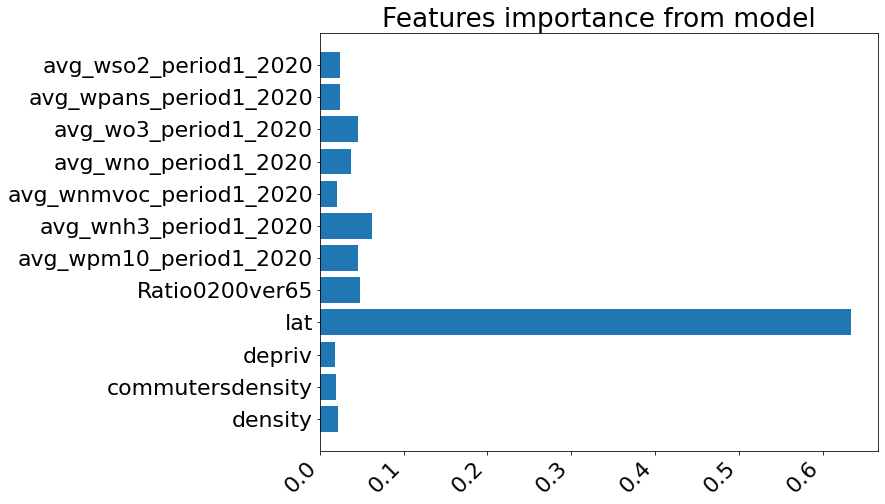

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03562 +/- 0.00383
Feature:               commutersdensity, Score: 0.02713 +/- 0.00368
Feature:                         depriv, Score: 0.04699 +/- 0.00363
Feature:                            lat, Score: 2.64014 +/- 0.33391
Feature:                 Ratio0200ver65, Score: 0.10055 +/- 0.01452
Feature:         avg_wpm10_period1_2020, Score: 0.08003 +/- 0.01150
Feature:          avg_wnh3_period1_2020, Score: 0.14129 +/- 0.02297
Feature:        avg_wnmvoc_period1_2020, Score: 0.04019 +/- 0.00577
Feature:           avg_wno_period1_2020, Score: 0.10616 +/- 0.01809
Feature:           avg_wo3_period1_2020, Score: 0.07939 +/- 0.00984
Feature:         avg_wpans_period1_2020, Score: 0.05079 +/- 0.00777
Feature:          avg_wso2_period1_2020, Score: 0.05317 +/- 0.00837


<Figure size 432x288 with 0 Axes>

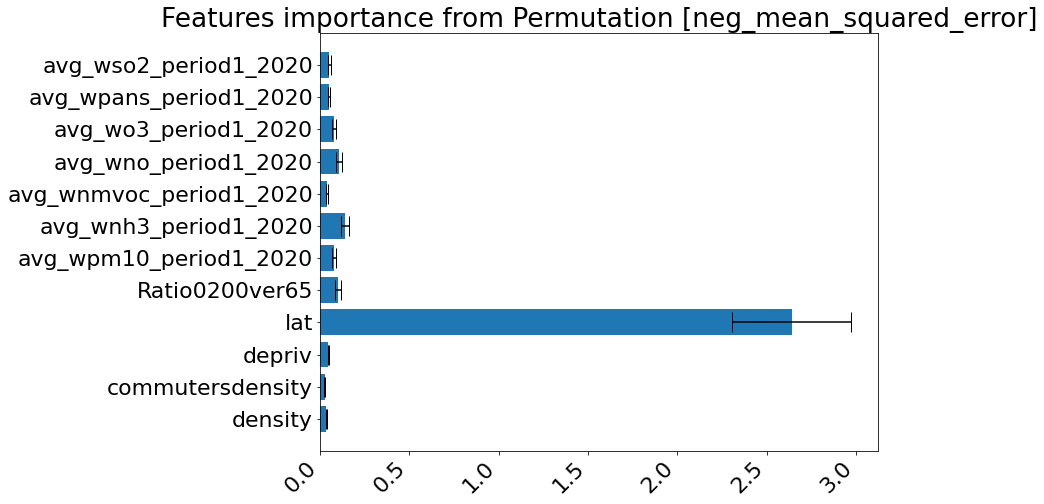

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01630 +/- 0.00175
Feature:               commutersdensity, Score: 0.01241 +/- 0.00169
Feature:                         depriv, Score: 0.02150 +/- 0.00166
Feature:                            lat, Score: 1.20816 +/- 0.15280
Feature:                 Ratio0200ver65, Score: 0.04601 +/- 0.00664
Feature:         avg_wpm10_period1_2020, Score: 0.03662 +/- 0.00526
Feature:          avg_wnh3_period1_2020, Score: 0.06466 +/- 0.01051
Feature:        avg_wnmvoc_period1_2020, Score: 0.01839 +/- 0.00264
Feature:           avg_wno_period1_2020, Score: 0.04858 +/- 0.00828
Feature:           avg_wo3_period1_2020, Score: 0.03633 +/- 0.00450
Feature:         avg_wpans_period1_2020, Score: 0.02324 +/- 0.00355
Feature:          avg_wso2_period1_2020, Score: 0.02433 +/- 0.00383


<Figure size 432x288 with 0 Axes>

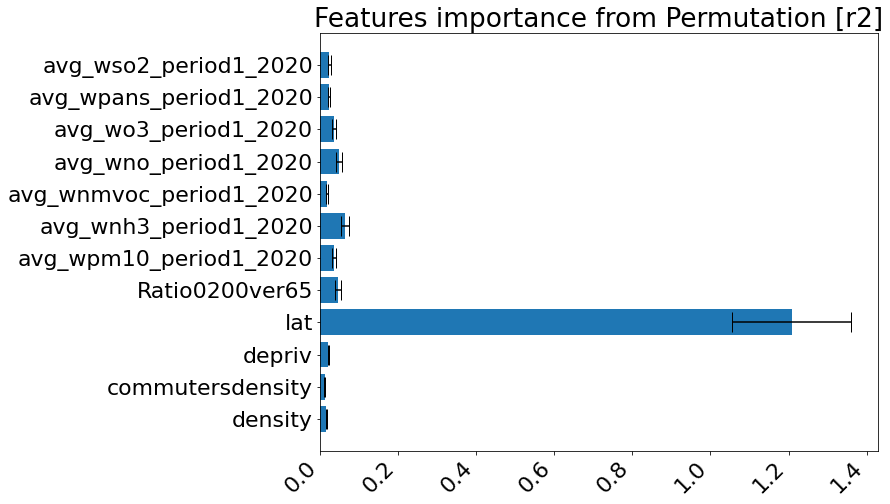

<Figure size 720x720 with 0 Axes>

((0.3528920876186338, 0.021548835589666134),
 (0.9427915616923209, 0.08938094626145586),
 0.3488062998364775,
 {'density': 0.010472880120461108,
  'commutersdensity': 0.00797532715989253,
  'depriv': 0.013813785909990687,
  'lat': 0.7761805034936128,
  'Ratio0200ver65': 0.02956040161492924,
  'avg_wpm10_period1_2020': 0.023528961209830966,
  'avg_wnh3_period1_2020': 0.04153897413552742,
  'avg_wnmvoc_period1_2020': 0.01181541262021339,
  'avg_wno_period1_2020': 0.031211497216208393,
  'avg_wo3_period1_2020': 0.023338683249811396,
  'avg_wpans_period1_2020': 0.014931997868986158,
  'avg_wso2_period1_2020': 0.015631575400535974},
 {'density': 0.010472880120461128,
  'commutersdensity': 0.007975327159892555,
  'depriv': 0.013813785909990713,
  'lat': 0.7761805034936122,
  'Ratio0200ver65': 0.029560401614929264,
  'avg_wpm10_period1_2020': 0.023528961209830987,
  'avg_wnh3_period1_2020': 0.041538974135527436,
  'avg_wnmvoc_period1_2020': 0.011815412620213408,
  'avg_wno_period1_2020': 0.03

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.12166583480561464
2  of  1200 MSE:  0.12138227024586429
3  of  1200 MSE:  0.17385004335596116
4  of  1200 MSE:  0.21754152398270932
5  of  1200 MSE:  0.4050515255859425
6  of  1200 MSE:  0.4973651883076264
7  of  1200 MSE:  0.5844333412401654
8  of  1200 MSE:  0.6886416331137711
9  of  1200 MSE:  0.16801562033066228
10  of  1200 MSE:  0.18939845316314805
11  of  1200 MSE:  0.19286762340858693
12  of  1200 MSE:  0.2426464368916062
13  of  1200 MSE:  0.4050515255859425
14  of  1200 MSE:  0.4973651883076264
15  of  1200 MSE:  0.5844333412401654
16  of  1200 MSE:  0.6886416331137711
17  of  1200 MSE:  0.2798218620637986
18  of  1200 MSE:  0.3282073253731522
19  of  1200 MSE:  0.30082876763683325
20  of  1200 MSE:  0.3604931054875538
21  of  1200 MSE:  0.4050515255859425
22  of  1200 MSE:  0.4973651883076264
23  of  1200 MSE:  0.5844333412401654
24  of  1200 MSE:  0.6886416331137711
25  of  1200 MSE:  0.36868824293760716
26  of  1200 MSE:  0.4334421081216814
27  of  1200

In [ ]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=bestf)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=bestf)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=bestf)